# Parametric Density Estimation and Clustering

Gordon Richards (2016, 2018, 2020) based on materials from Vanderplas, Leighly, Thibert, and Ivezic 4.4, 6.3, 6.4, 6.6.

With asides on [StandardScalar](https://scikit-learn.org/stable/modules/preprocessing.html?highlight=standard%20scalar) and [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

## Gaussian Mixture Models (GMM)

KDE centers each bin (or kernel rather) at each point.  In a [**mixture model**](https://en.wikipedia.org/wiki/Mixture_model) we don't use a kernel for each data point, but rather we fit for the *locations of the kernels*--in addition to the width.  So a mixture model is sort of a hybrid between a tradtional (fixed bin location/size) histogram and KDE.   Using lots of kernels (maybe even more than the BIC score suggests) may make sense if you just want to provide an accurate description of the data (as in density estimation).  Using fewer kernels makes mixture models more like clustering (later today), where the suggestion is still to use many kernels in order to divide the sample into real clusters and "background".

Gaussians are the most commonly used components for mixture models.  So, the pdf is modeled by a sum of Gaussians:
$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$
where $\alpha_k$ are the "mixing coefficients" with $0\le \alpha_k \le 1$ and $\sum_{k=1}^N \alpha_k = 1$.

We can solve for the parameters using maximum likelihood analyis as we have discussed previously.
However, this can be complicated in multiple dimensions, requiring the use of [**Expectation Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) methods.

Ivezic Figure 4.2 (next cell) provides an example in 1-D.

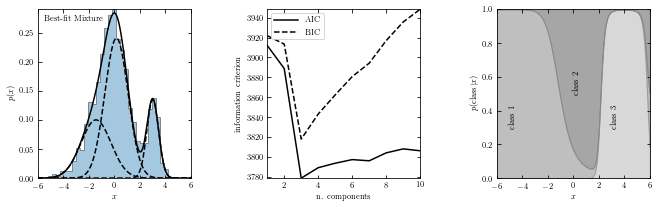

In [1]:
# Ivezic v2, Figure 4.2
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

Here we have some data that we are trying to describe with a mixture of between 1 and 10 Gaussians.  The figure shows an example where 3 Gaussians provides the best fit.

Again, the distribution is modeled as 

$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$
with $0\le \alpha_k \le 1$ controlling the relative high of the Gaussians.  We use Expectation Maximization to determine the properties of each Gaussian ($\alpha$, $\mu_k$,and $\Sigma_k$).

### Expectation Maximization (ultra simplified version)

(Note: all explanations of EM are far more complicated than seems necessary for our purposes, so here is my overly simplified explanation.)

This may make more sense in terms of our earlier Bayesian analyses if we write this as 
$$p(z=c) = \alpha_k,$$
and
$$p(x|z=c) = \mathscr{N}(x|\mu_k,\Sigma_k),$$
where $z$ is a "hidden" variable related to which "component" each point is assigned to.

In the Expectation step, we hold $\mu_k, \Sigma_k$, and $\alpha_k$ fixed and compute the probability that each $x_i$ belongs to component, $c$.  

In the Maximization step, we hold the probability of the components fixed and maximize $\mu_k, \Sigma_k,$ and $\alpha_k$.

We can use the following 2-D animation to illustrate the process.  

We start with a 2-component GMM, where the initial components can be randomly determined.

The points that are closest to the centroid of a component will be more probable under that distribution in the "E" step and will pull the centroid towards them in the "M" step.  Iteration between the "E" and "M" step eventually leads to convergence.

In this particular example, 3 components better describes the data and similarly converges.  Note that the process is not that sensitive to how the components are first initialized.  We pretty much get the same result in the end.

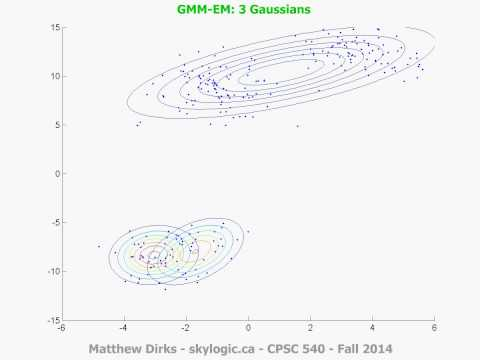

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("B36fzChfyGU")

A typical call to the [Gaussian Mixture Model](http://scikit-learn.org/stable/modules/mixture.html) algorithm looks like this:

In [3]:
# Execute this cell
import numpy as np
from sklearn.mixture import GaussianMixture

X = np.random.normal(size=(1000,2)) #1000  points in 2D
gmm = GaussianMixture(3) #three components
gmm.fit(X)
log_dens = gmm.score(X)
BIC = gmm.bic(X)

Let's do the 1-D example given using eruption data from "Old Faithful" geyser at Yellowstone National Park.  
[http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat](http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat).

In [4]:
#eruptions: Eruption time in mins
#waiting: Waiting time to next eruption
import pandas as pd
df = pd.read_csv('../../PHYS_440_540/data/faithful.dat', delim_whitespace=True)
df.head()

,N,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


Make two "fancy" histograms illustrating the distribution of `x=df['eruptions']` and `y=df['waiting']` times.  Use `bins="freedman"` and `histtype="step"`.

Text(0, 0.5, 'N')

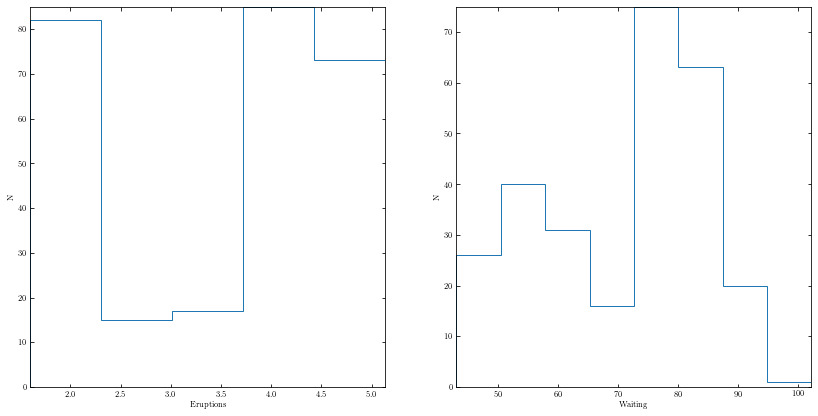

In [5]:
from matplotlib import pyplot as plt
from astropy.visualization import hist as fancyhist
%matplotlib inline

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
fancyhist(df['eruptions'],bins="freedman",histtype="step")
plt.xlabel('Eruptions')
plt.ylabel('N')

ax = fig.add_subplot(122)
fancyhist(df['waiting'],bins="freedman",histtype="step")
plt.xlabel('Waiting')
plt.ylabel('N')

In [6]:
#Fit Gaussian Mixtures, first in 1-D
from sklearn.mixture import GaussianMixture

#First fit Eruptions
gmm1 = GaussianMixture(n_components=2) # 2-component gaussian mixture model
gmm1.fit(df['eruptions'][:,None]) # Fit step
xgrid1 = np.linspace(0, 8, 1000) # Make evaluation grid
logprob1 = gmm1.score_samples(xgrid1[:,None]) # Compute log likelihoods on that grid
pdf1 = np.exp(logprob1)
resp1 = gmm1.predict_proba(xgrid1[:,None]) 
pdf_individual1 = resp1 * pdf1[:, np.newaxis] # Compute posterior probabilities for each component

<ipython-input-6-f0b54715bd28>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gmm1.fit(df['eruptions'][:,None]) # Fit step


In [7]:
#Then fit waiting
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(df['waiting'][:, None])
xgrid2 = np.linspace(30, 120, 1000)
logprob2 = gmm2.score_samples(xgrid2[:, None])
pdf2 = np.exp(logprob2)
resp2 = gmm2.predict_proba(xgrid2[:, None])
pdf_individual2 = resp2 * pdf2[:, np.newaxis]

<ipython-input-7-669d4cb97daf>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gmm2.fit(df['waiting'][:, None])


Text(0.5, 0, 'Waiting')

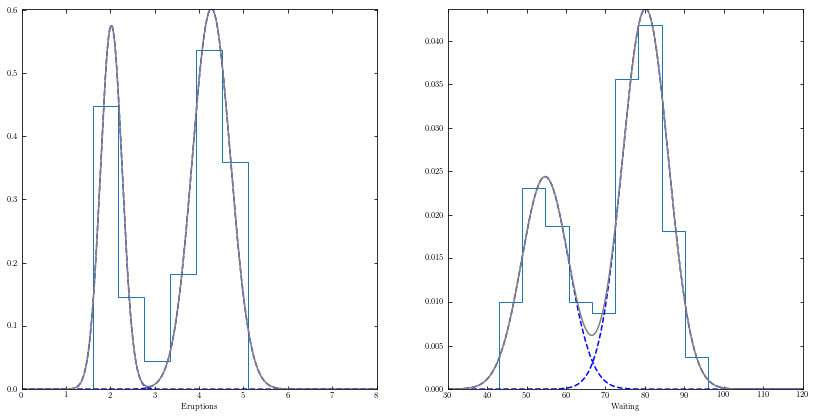

In [8]:
#Make plots
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
plt.hist(df['eruptions'], bins=6, density=True, histtype='step')
plt.plot(xgrid1, pdf_individual1, '--', color='blue')
plt.plot(xgrid1, pdf1, '-', color='gray')
plt.xlabel("Eruptions")

ax = fig.add_subplot(122)
plt.hist(df['waiting'], bins=9, density=True, histtype="step")
plt.plot(xgrid2, pdf_individual2, '--', color='blue')
plt.plot(xgrid2, pdf2, '-', color='gray')
plt.xlabel("Waiting")

Let's now do a more complicated 1-D example (Ivezic, Figure 6.8), which compares a Mixture Model to KDE.
[Note that the version at astroML.org has some bugs!]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass bandwidth=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass bandwidth=0.1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


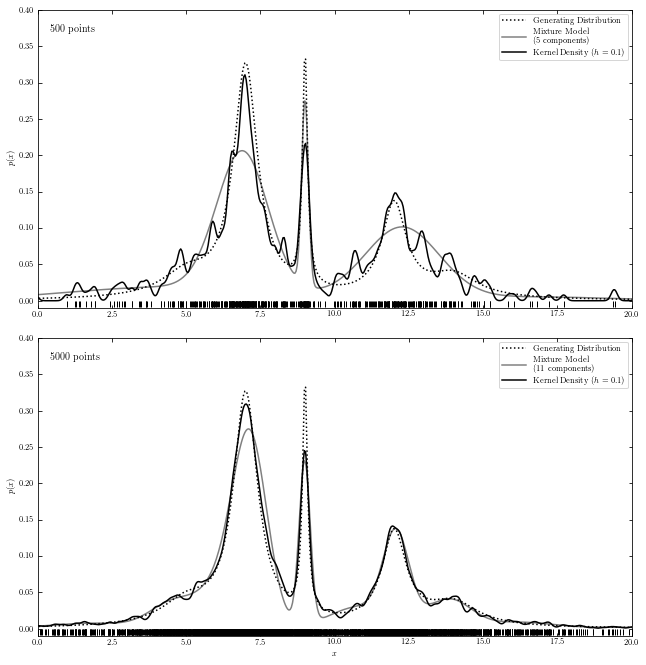

In [9]:
# Execute this cell
# Ivezic, Figure 6.8, modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    kde = KernelDensity(0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    n_components = np.arange(3, 20)
    gmms = [GaussianMixture(n_components=n).fit(xN[:,None]) for n in n_components]
    BICs = [gmm.bic(xN[:,None]) for gmm in gmms]
    i_min = np.argmin(BICs)
    t = np.linspace(-10, 30, 1000)
    logprob = gmms[i_min].score_samples(t[:,None])

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k', lw=1.5)
    ax.plot(t, np.exp(logprob), '-', color='gray',
            label="Mixture Model\n(%i components)" % n_components[i_min])
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density $(h=0.1)$")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

Let's plot the BIC values and see why it picked that many components.

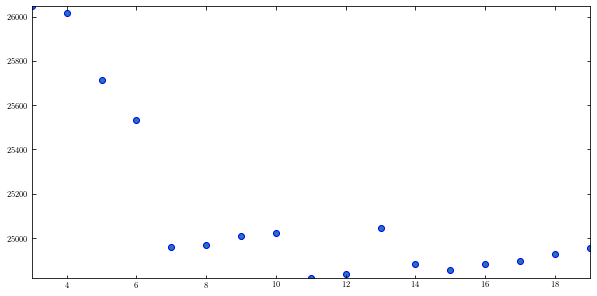

In [10]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(n_components,BICs)
plt.show()

What do the individual components look like?  Make a plot of those.  Careful with the shapes of the arrays!

[GaussianMixture(n_components=3), GaussianMixture(n_components=4), GaussianMixture(n_components=5), GaussianMixture(n_components=6), GaussianMixture(n_components=7), GaussianMixture(n_components=8), GaussianMixture(n_components=9), GaussianMixture(n_components=10), GaussianMixture(n_components=11), GaussianMixture(n_components=12), GaussianMixture(n_components=13), GaussianMixture(n_components=14), GaussianMixture(n_components=15), GaussianMixture(n_components=16), GaussianMixture(n_components=17), GaussianMixture(n_components=18), GaussianMixture(n_components=19)]


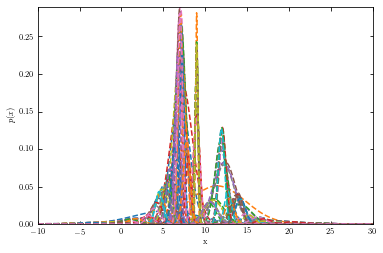

In [11]:
print(gmms)

plt.figure()
plt.xlabel('x')
plt.ylabel('$p(x)$')

for i, gaussianmixture in enumerate(gmms):
    gaussianmixture.fit(xN[:,None])
    xgrid2 = t
    logprob2 = gaussianmixture.score_samples(t[:, None])
    pdf2 = np.exp(logprob2)
    resp2 = gaussianmixture.predict_proba(t[:, None])
    pdf_individual2 = resp2 * pdf2[:, np.newaxis]
    
    plt.plot(t, pdf_individual2, '--')

plt.show()

11


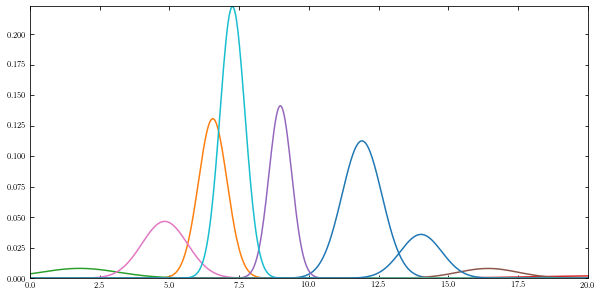

In [12]:
# See Ivezic, Figure 4.2 for help: http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html
# The index "8" is choosing the instance with 11 components.
fig = plt.figure(figsize=(10, 5))
print(len(gmms[8].weights_))
logprob =  gmms[8].score_samples(t[:,None])
pdf = np.exp(logprob) # Sum of the individual component pdf
resp = gmms[8].predict_proba(t[:,None]) # Array of "responsibilities" for each component
pdf_individual = resp*pdf[:,None]
plt.plot(t,pdf_individual)
plt.xlim((0,20))
plt.show()

Now let's look at the Old Faithful data again, but this time in 2-D.

(40.0, 100.0)

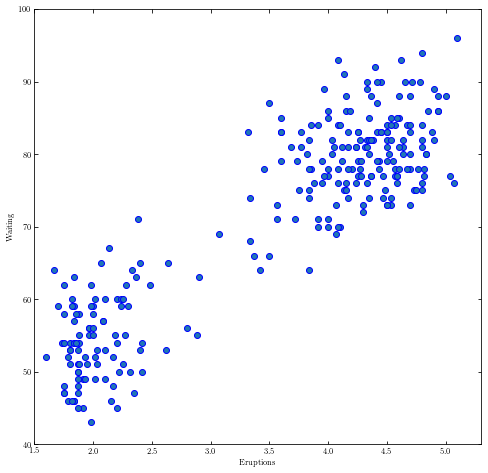

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(df['eruptions'],df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.xlim([1.5,5.3])
plt.ylim([40,100])

Now we'll fit both features at the same time (i.e., the $x$ and $y$ axes above) with `n_components=2`.  Note that Scikit-Learn can handle Pandas DataFrames without further conversion.

In [14]:
gmm3 = GaussianMixture(n_components=2)
gmm3.fit(df[['eruptions','waiting']]) #Note no need for "None"

GaussianMixture(n_components=2)

Once the components have been fit, we can plot the location of the centroids and the "error" ellipses.

In [15]:
#Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

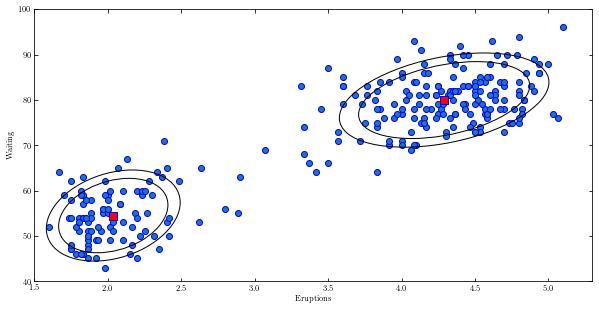

In [16]:
#See cell above
#from astroML.plotting.tools import draw_ellipse

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.scatter(df['eruptions'],df['waiting'])
plt.xlabel('Eruptions')
plt.ylabel('Waiting')
plt.xlim([1.5,5.3])
plt.ylim([40,100])

ax.scatter(gmm3.means_[:,0], gmm3.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm3.means_, gmm3.covariances_, gmm3.weights_):
    draw_ellipse(mu, 2*C, scales=[1], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component
#Add a 3-sigma error ellipse    
for mu, C, w in zip(gmm3.means_, gmm3.covariances_, gmm3.weights_):
    draw_ellipse(mu, 3*C, scales=[1], ax=ax, fc='none', ec='k')


Ivezic, Figure 6.6 shows another 2-D example.  In the first panel, we have the raw data.  We then try to represent the data with a series of Gaussians.  We allow up to 14 Gaussians and use the AIC/BIC to determine the best choice for this number.  This is shown in the second panel.  Finally, the third panel shows the chosen Gaussians with their centroids and 1-$\sigma$ contours on top of a density plot of our data.

In this case 5 components are required for the best fit.  While it looks like we could do a pretty good job with just 2 components, there does appear to be some "background" that is a high enough level to justify further components.

@pickle_results: using precomputed results from 'GMM_metallicity.pkl'
best fit converged: True
BIC: n_components =  5


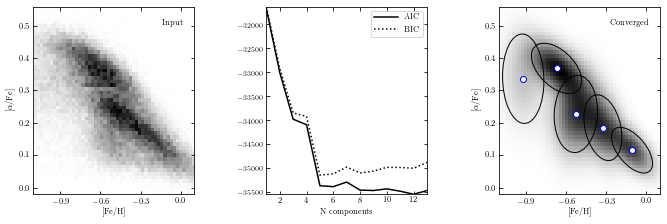

In [17]:
# Execute this cell
# Ivezic, Figure 6.6
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_sdss_sspp
from astroML.utils.decorators import pickle_results
#See cells above
#from astroML.plotting import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get the Segue Stellar Parameters Pipeline data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute GaussianMixture models & AIC/BIC
N = np.arange(1, 14)


@pickle_results("GMM_metallicity.pkl")
def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print(N[i])
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

#------------------------------------------------------------
# compute 2D density
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.45,
                    bottom=0.25, top=0.9,
                    left=0.1, right=0.97)

# plot density
ax = fig.add_subplot(131)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.text(0.93, 0.93, "Input",
        va='top', ha='right', transform=ax.transAxes)

# plot AIC/BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(133)
ax.imshow(np.exp(log_dens),
          origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.text(0.93, 0.93, "Converged",
        va='top', ha='right', transform=ax.transAxes)

ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

Talk about how to use this to do outlier finding.  Convolve with errors of unknown object.

Lastly, let's look at a 2-D case where we are using GMM more to characterize the data than to find clusters.  

<ipython-input-18-a78c1db6fd6b>:51: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),


@pickle_results: using precomputed results from 'great_wall_GMM.pkl'


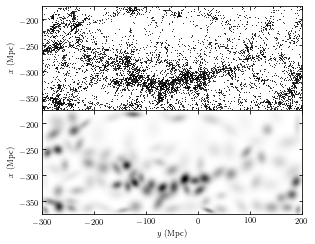

In [18]:
# Ivezic v2, Figure 6.7
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall
from astroML.utils.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# load great wall data
X = fetch_great_wall()


#------------------------------------------------------------
# Create a function which will save the results to a pickle file
#  for large number of clusters, computation will take a long time!
@pickle_results('great_wall_GMM.pkl')
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

#------------------------------------------------------------
# Compute a grid on which to evaluate the result
Nx = 100
Ny = 250
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

#------------------------------------------------------------
# Compute the results
#
# we'll use 100 clusters.  In practice, one should cross-validate
# with AIC and BIC to settle on the correct number of clusters.
clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()

Note that this is very different than the non-parametric density estimates.  The advantage is that we now have a *model*.  This model can be stored very compactly with just a few numbers, unlike the KDE or KNN maps which require a floating point number for each grid point.  

One thing that you might imagine doing with this is subtracting the model from the data and looking for interesting things among the residuals.

---

## Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithms attempt to group together like objects in a data set.  This process allows us to put new objects into the resulting classes and to identify rare objects that do not fit any particular mold.  Clustering is inherently an "unsupervised" process as we do not know the classification of the objects.  Since we have no metric for determining when we are right, it is a bit of a dark art, but it also can be very powerful.  Scikit-Learn's clustering suite is summarized at [http://scikit-learn.org/stable/modules/clustering.html](http://scikit-learn.org/stable/modules/clustering.html).

### $K$-Means Clustering

We start with [$K$-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), which is one of the simplest methods.  $K$-means seeks to minimize the following

$$\sum_{k=1}^{K}\sum_{i\in C_k}||x_i - \mu_k||^2$$

where $\mu_k = \frac{1}{N_k}\sum_{i\in C_k} x_i$

This says to
  * Take every object in class $C_k$ (as determined by which centroid it is closest to, specifically $C_k(x_i) = \arg \min_k ||x_i-\mu_k||)$
  * Compute the mean of the objects in that class
  * Subtract that mean from each member of that class and square the norm
  * Do that for each class and sum
  * Shift the centroids of the *pre-determined* number of classes until this sum is minimized
  * Do this multiple times with different starting centroids and take the result with the minimum sum

A typical call will look something like this

In [19]:
# Execute this cell
import numpy as np
from sklearn.cluster import KMeans

X = np.random.normal(size=(1000,2)) #1000 points in 2D
clf = KMeans(n_clusters=3) #Try 3 clusters to start with
clf.fit(X)
centers=clf.cluster_centers_ #location of the clusters
labels=clf.predict(X) #labels for each of the points

# To get some information on these try:
# KMeans?
# help(clf)

Here is an example with the same data that we used for GMM.  Note how the background shifts the centroids from what you might expect.  So, the mixture model might work better in this case.

However, one might consider running the K-means algorithm in order to find a suitable initialization for GMM. 

<ipython-input-20-070e065d1b90>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


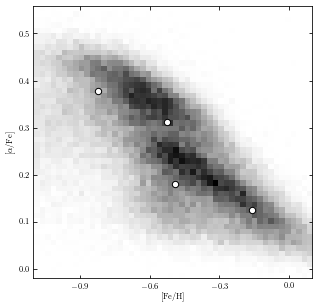

In [20]:
# Ivezic v2, Figure 6.13
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get data
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

#------------------------------------------------------------
# Compute a 2D histogram  of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

#------------------------------------------------------------
# Compute the KMeans clustering
n_clusters = 4

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

#------------------------------------------------------------
# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

#H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
#
#for i in range(n_clusters):
#    Hcp = H.copy()
#    flag = (Hcp == i)
#    Hcp[flag] = 1
#    Hcp[~flag] = 0
#
#    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
#               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

A few things to note
* This was supposed to show the boundaries between the clusters, but it isn't working.  See another example below.
* We scaled the data (subtracted the mean and scaling to unit variance) using `StandardScaler()` before running K-Means
* We had to *un*scale the data to plot the centers
* Plotting the cluster boundaries is not straightforward, but this gives you an example to work with

Let's do an example with unscaled then scaled data so you can see how that works.

In [21]:
from sklearn.datasets import make_blobs
#Make two blobs with 3 features
X,y = make_blobs(n_samples=100, centers=2, n_features=3, random_state=42)

In [22]:
print(X[:5,:],y[:5])

[[  3.8389442   -6.40579427  -8.07141309]
 [  1.25786597  -6.20002944  -7.61047622]
 [  1.91364433 -10.12089453  -7.90449723]
 [  2.2804692   -6.06676507  -6.25048075]
 [ -2.58120774  10.01781903   5.00151486]] [1 1 1 1 0]


In [23]:
#Now make one of those features have a radically different scale
X[:,0] = X[:,0]+100

In [24]:
print(X[:5,:],y[:5])

[[103.8389442   -6.40579427  -8.07141309]
 [101.25786597  -6.20002944  -7.61047622]
 [101.91364433 -10.12089453  -7.90449723]
 [102.2804692   -6.06676507  -6.25048075]
 [ 97.41879226  10.01781903   5.00151486]] [1 1 1 1 0]


In [25]:
#Make a scaled version of X (subtract the mean and divide by the standard deviation)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
print(X_scaled[:5,:],y[:5])

[[ 1.60328498 -0.89976569 -1.24199135]
 [ 0.57836209 -0.87436159 -1.16056485]
 [ 0.83876576 -1.35843882 -1.21250494]
 [ 0.98442861 -0.85790852 -0.92031574]
 [-0.94609948  1.12792389  1.06739818]] [1 1 1 1 0]


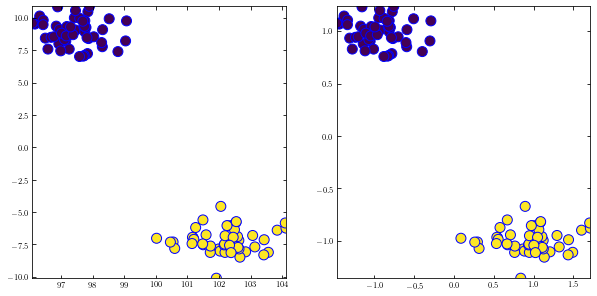

In [27]:
#Plot the unscaled and scaled data
fig,ax = plt.subplots(1,2,figsize=(10, 5))

ax[0].scatter(X[:, 0], X[:, 1], s=100, c=y)
ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], s=100, c=y)

In [28]:
#Do KMeans clustering with 2 clusters on the scaled data.
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=2) #Make 2 clusters to start with
clf.fit(X_scaled)
centers=clf.cluster_centers_ #location of the clusters
labels=clf.predict(X_scaled) #labels for each of the points


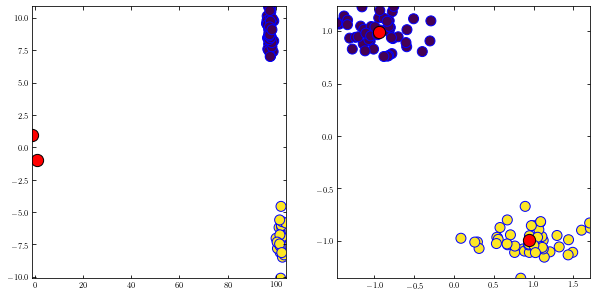

In [29]:
#Plot the unscaled and scaled data and the centers that we just computed
fig,ax = plt.subplots(1,2,figsize=(10, 5))

ax[0].scatter(X[:, 0], X[:, 1], s=100, c=labels)
ax[0].scatter(centers[:, 0], centers[:, 1], s=150, c='red', edgecolors='k')

ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], s=100, c=labels)
ax[1].scatter(centers[:, 0], centers[:, 1], s=150, c='red', edgecolors='k')

Because the centers were computed with the scaled data, they don't correspond to the original (unscaled) data points. But we can do an inverse transform if we want to be able to plot the data in its natural units.

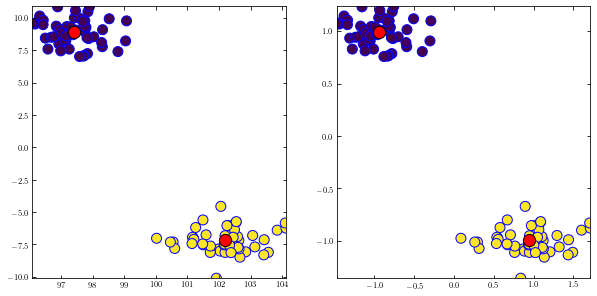

In [30]:
#Unscale the centers and try again
centers_unscaled = scaler.inverse_transform(centers)

#Plot the unscaled and scaled data
fig,ax = plt.subplots(1,2,figsize=(10, 5))

ax[0].scatter(X[:, 0], X[:, 1], s=100, c=labels)
ax[0].scatter(centers_unscaled[:, 0], centers_unscaled[:, 1], s=150, c='red', edgecolors='k')

ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], s=100, c=labels)
ax[1].scatter(centers[:, 0], centers[:, 1], s=150, c='red', edgecolors='k')

Note that because of the standardization enabled by the Scikit-Learn API, it is easy to chain operations together into a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).  See below for a very simple example of how to do the same thing that we did above.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
                 
pipe.fit(X)
centers=pipe['kmeans'].cluster_centers_ #location of the clusters
labels=pipe.predict(X) #labels for each of the points

Lastly, K-means is great for idealized data (roughly spherical clusters of similar density), it has some problems with more complicated situations.  The following situation may not be realistic, but it illustrates where we can run into problems.

In [32]:
#Create two samples that are not spherically symmetric and try Kmeans.
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

In [33]:
clf = KMeans(n_clusters=2) #Try 2 clusters as there are clearly 2 by eye
clf.fit(X)
centers=clf.cluster_centers_ #location of the clusters
labels=clf.predict(X) #labels for each of the points

(-1.0, 1.5)

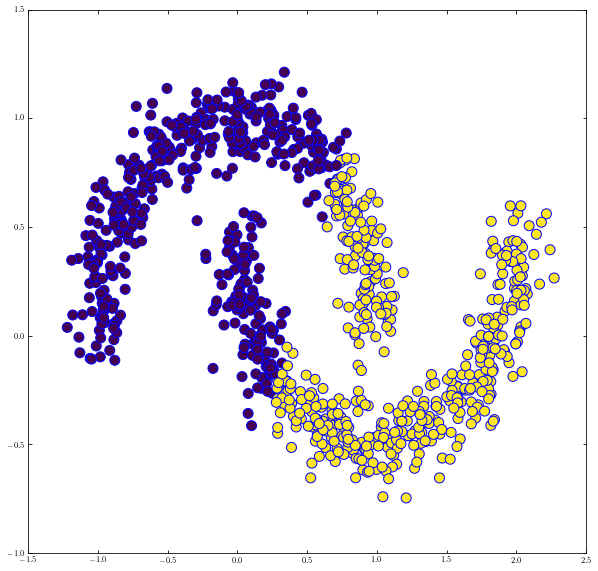

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=100, c=labels)

plt.xlim(-1.5, 2.5)
plt.ylim(-1.0, 1.5)

Not so great.  

Let's try another algorithm, [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html), which is "A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise".  This isn't discussed in the Ivezic book, but the link will take you to the description given in Scikit Learn.

In [49]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    #plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

    plt.show()

Note that DBSCAN is *very* sensitive to these parameters.  Here we'll just do trial and error.  Try a few values of `eps` between 0.05 and 0.2 and `min_samples` between 3 and 10.

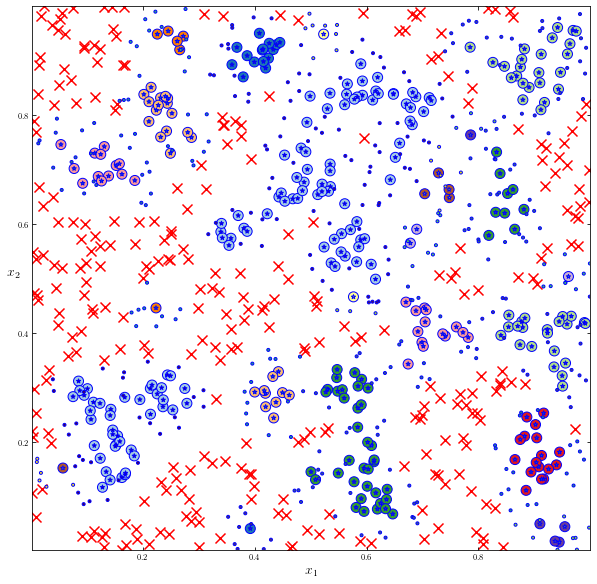

In [55]:
from sklearn.cluster import DBSCAN
#dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan = DBSCAN(eps=0.05, min_samples=10)
dbscan.fit(X)

plt.figure(figsize=(10, 10))
plot_dbscan(dbscan, X, size=100)

Not only is DBSCAN telling you which cluster each object belongs to, it is also "outliers" (denoted by the red crosses), which is another important use of clustering algorithms.

Here is an example from Prof. Cruz, showing K-means boundaries (which were not working in our example above).

In [37]:
# Execute the next few cells
from astropy.table import Table
t = Table.read('../../PHYS_440_540/data/cruz_all_dist.dat', format="ascii")

# Just something that you should know that you can do
t[::10000].show_in_notebook(display_length=10)

idx,col1,col2,col3,col4,col5
0,0,13.036360391315469,-0.11023486649375588,9.042417323170756,0.0
1,10000,9.023696954153493,0.8293214314891275,6.833193199727921,6.606296062469482
2,20000,8.91859322146936,0.07674335777677606,6.486594682475689,6.344982147216797
3,30000,7.771219058937069,-0.5512836769426659,6.830321011209626,5.607421398162842
4,40000,5.760398461368901,-0.07084221629151112,6.623958464771678,5.155749797821045
5,50000,9.415129029681331,-0.05102255815152851,7.132100193731942,5.606935977935791
6,60000,12.2001243155405,-0.044045115697908976,8.019024077980015,5.005303382873535
7,70000,11.553345499374842,0.13813429188811258,7.043892413779151,5.7191643714904785
8,80000,12.299447258890295,-0.11520621789057695,7.619906665721088,4.716273307800293
9,90000,11.39593275396183,0.8209362936061817,7.153943404249784,5.146049976348877


In [38]:
# Turn these data into a properly formatted Scikit-Learn array
X = np.vstack([ t['col2'], t['col3'], t['col4'], t['col5'] ]).T
print(X)

[[13.03636039 -0.11023487  9.04241732  0.        ]
 [13.33267828 -0.10360584  9.35453197  0.68184119]
 [13.14338559 -0.16142859  9.30932842  0.82017946]
 ...
 [ 6.77437708 -0.12553107  5.54210446  7.41862726]
 [ 6.71834403  0.04474092  5.56965196  7.44040775]
 [ 7.02729337  0.12547728  5.55979252  7.49615526]]


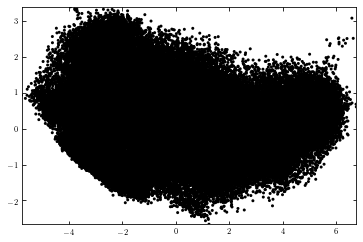

In [39]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting

X_reduced = pca.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], marker=".", color='k', edgecolors='None')

In [40]:
# Compute the KMeans clustering
n_clusters = 6
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

KMeans(n_clusters=6)

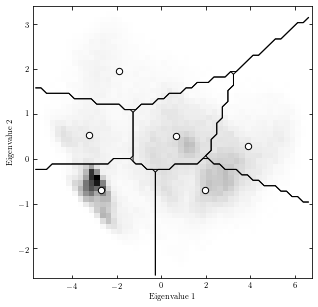

In [41]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
#ax = plt.axes()
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap=plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    
    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
#ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

#plt.savefig('cruz.png')
plt.show()

---

## Hierarchical Clustering

In [Hierarchical Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), we don't specify the number of clusters ahead of time, we start with $N$ clusters representing each data point.  Then the most similar clusters are joined together, the process repeating until some threshhold is reached.  Actually the process can go in the other direction as well.  What results is called a *dendrogram*, an example of which is shown below.

![](https://onlinecourses.science.psu.edu/stat505/sites/onlinecourses.science.psu.edu.stat505/files/lesson12/dendogram_example.gif)

Clusters are merged at each step according to which are "nearest" to each other---where the definition of nearest needs to be specified.  A typical choice results in what is called a "minimum spanning tree" (which can be quite slow for large data sets).  Some threshhold needs to be specified to tell the process where to stop (e.g., we are going to treat the green and red objects in the example above as separate clusters).  

![Here is an illustration](https://www.statisticshowto.com/wp-content/uploads/2016/11/clustergram.png)

Below is an example call.

In [42]:
# Execute this cell
import numpy
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.neighbors import kneighbors_graph

X = np.random.random((1000,2))
G = kneighbors_graph(X, n_neighbors=10, mode='distance')
T = minimum_spanning_tree(G)

OK, but that's all that the book give us.  There is nothing about what to do with `G` and `T`.  So, instead I'm going to show you a really cool example from a colleague.  In this example Nathalie Thibert is taking spectroscopic data of a certain sub-class of quasars.  She is then grouping the objects into "like" bins using a hierarchical clustering algorithm.  The code below is based on the [scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) and takes us through both the analysis and visualization of the data.  It makes use of the [Python Data Analysis Library (pandas)](http://pandas.pydata.org/) and ['pickled'](https://docs.python.org/2/library/pickle.html) 
data, the latter of which we have not talked about.

For another detailed example of hierarchical clustering, see [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/).

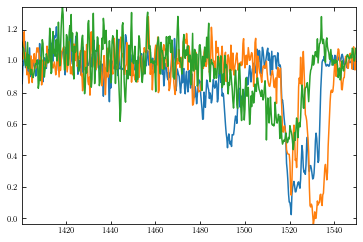

In [43]:
%matplotlib inline
# %load code/thibert_cluster1.py
## Hierarchical Clustering Example: BAL Quasar UV Spectra (pre-reduced)
## Author: Nathalie C. M. Thibert (Saint Mary's University), modified from
## 	   code by Mark Daley (Western University)
##
## Method: Agglomerative Hierarchical Clustering
## Distance Metric: Complete Linkage
## Data: 100 BAL Quasar UV Spectra over ~1400-1550 Ang (i.e., the C IV BAL) 
##	 Spectra are already in rest-frame, normalized to the local continuum 
## 	 and emission lines, and resampled to a common wavelength grid. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

# import clustering algorithms from scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

# Import pickled BAL quasar data.
#data = pd.DataFrame(pd.read_pickle('../data/balquasar_data.pkl')) # Should have 500 wavelength values and 100 spectra.
data = pd.read_pickle('../../PHYS_440_540/data/balquasar_data_new.pkl') # Should have 500 wavelength values and 100 spectra.


# Over plot some example spectra
wl = np.arange(1400.1,1549.8,0.3)
spec0 = data.T.iloc[0] # You can change the index to see different spectra (choose 0,1,2,...,99).
spec5 = data.T.iloc[5]
spec7 = data.T.iloc[7]
plt.figure() 
plt.plot(wl,spec5)
plt.plot(wl,spec0)
plt.plot(wl,spec7)
plt.show()

<ipython-input-44-acc161540f1a>:31: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(de1, method='complete') # This is where the hierarchical clustering takes place.
<ipython-input-44-acc161540f1a>:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = linkage(de2, method='complete')
<ipython-input-44-acc161540f1a>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


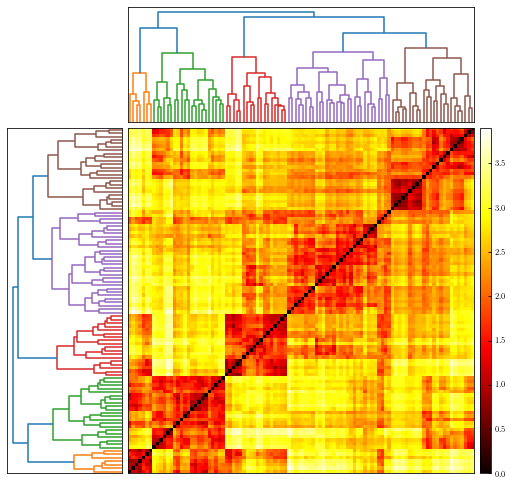

In [44]:
# %load code/thibert_cluster2.py
## Hierarchical Clustering Example: BAL Quasar UV Spectra (pre-reduced)
## Author: Nathalie C. M. Thibert (Saint Mary's University), modified from
## 	   code by Mark Daley (Western University)
##
## Method: Agglomerative Hierarchical Clustering
## Distance Metric: Complete Linkage
## Data: 100 BAL Quasar UV Spectra over ~1400-1550 Ang (i.e., the C IV BAL) 
##	 Spectra are already in rest-frame, normalized to the local continuum 
## 	 and emission lines, and resampled to a common wavelength grid. 


# Compute Pearson correlation matrix for 100 spectra. 
# Each element is a pairwise comparison b/w two spectra.
c = data.corr() # Should have 100 rows and 100 columns.

# Compute absolute-valued Pearson distance matrix.
dp = 1.0 - np.abs(c)

# Compute Euclidean distance matrix for the first dendrogram
de1 = squareform(pdist(dp,metric='euclidean')) 

# Do it again for the second dendrogram
de2 = squareform(pdist(dp.T,metric='euclidean'))

# Start the dendrogram plot.
f = plt.figure(figsize=(8, 8))

# Add the first dendrogram (on the left side)
ax1 = f.add_axes([0.09, 0.1, 0.2, 0.6])
Y = linkage(de1, method='complete') # This is where the hierarchical clustering takes place.
Z1 = dendrogram(Y, orientation='left',show_leaf_counts=False, no_labels=True) # Plots dendrogram.
ax1.set_xticks([])
ax1.set_yticks([])

# Add the second dendrogram (on the top)
ax2 = f.add_axes([0.3, 0.71, 0.6, 0.2])
Y = linkage(de2, method='complete')
Z2 = dendrogram(Y,show_leaf_counts=False, no_labels=True)
ax2.set_xticks([])
ax2.set_yticks([])

# Add the (main) plot of the (clustered) Euclidean distance matrix.
axmatrix = f.add_axes([0.3, 0.1, 0.6, 0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = de1[idx1, :]
D = D[:, idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap='hot')
axmatrix.set_xticks([])
axmatrix.set_yticks([])
    
axcolor = f.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im,cax=axcolor)
f.show()

## NOTE: The colours in the dendrograms correspond to a flat clustering given 
##	 the default distance threshold in Python.

Note that the side and top dendrograms are the same data.  It is just that the 2-D visualization better lets us see what groups go together.

I don't pretend to fully understand each step of this process, but the end result is really cool and I think that there is enough here to get you started if we were interested in trying to implement it.

Summary of Chapter 6 methods from Ivezic Table 6.1 

|Method          |Accuracy|Interpretability|Simplicity|Speed|
|----------------|--------|----------------|----------|-----|
|K-nearest Neighbor| H | H | H | M |
|Kernel Density Estimation| H | H | H | H |
|Gaussian Mixture Models| H | M | M | M |
|Extreme Deconvolution| H | H | M | M |
||||||
|K-Means| L | M | H | M |
|Max-radius minimization| L | M | M | M |
|Mean shift| M | H | H | M |
|Hierarchical Clustering| H | L | L | L |